# Deep Learning for Computer Vision: Convolutional Neural Networks (CNNs)

CNNs automatically learn hierarchical features from data, often outperforming hand-crafted features. Early layers are interpretable (edges, textures), while deeper layers capture more abstract patterns that are harder to interpret.

This is achieved by stacking multiple layers of learnable filters, similar in spirit to the manual filtering explored in the "1_filtering" notebook, but learned directly from data. In practice, the early layers tend to capture simple edges, corners, and textures, while later layers combine these into higher-level visual concepts.

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


Example FashionMNIST (classifying images of clothes)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=5, shuffle=False)

Visualizing the data:

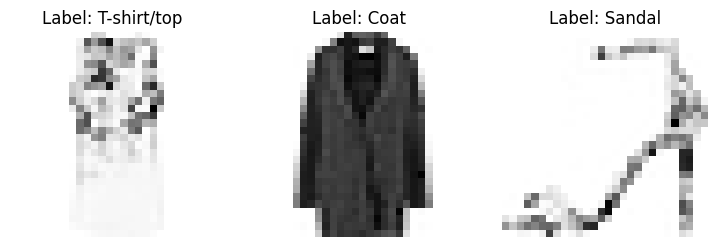

In [3]:
images, labels = next(iter(trainloader))

plt.figure(figsize=(9,3))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.Greys)
    plt.title(f"Label: {classes[labels[i].item()]}")
    plt.axis("off")

plt.show()


In [4]:
device = "cpu"

Example net: Small VGG style net

In [5]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 20, 3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            
            nn.Conv2d(20, 20, 3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            
            nn.Conv2d(20, 20, 3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(20, 40, 3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            
            nn.Conv2d(40, 40, 3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            
            nn.Conv2d(40, 40, 3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(40, 60, 3),
            nn.BatchNorm2d(60),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(60, 40, 1),
            nn.BatchNorm2d(40),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(40, 20, 1),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )
        self.avg1 = nn.AvgPool2d(5)
        self.fc1 = nn.Linear(20, 10)
        
    def forward(self, x, verbose=False):

        c1 = self.block1(x)
        c2 = self.block2(c1)
        c3 = self.conv1(c2)
        c4 = self.conv2(c3)
        c5 = self.conv3(c4)
        c6 = self.avg1(c5)
        c6 = torch.flatten(c6, 1)
        c7 = self.fc1(c6)
        y = c7
        
        return y
        

In [6]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [7]:
net = VGGNet()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
epochs = 10

def train(model, train, test, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):

        for i, (x, y) in enumerate(train):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_predicted = model(x)

            loss = criterion(y_predicted, y)
            loss.backward()
            optimizer.step()

        accuracy = compute_accuracy(model, test)
        print("epoch", epoch+1, "|", accuracy)

train(net, trainloader, testloader, optimizer, criterion, device, epochs)

epoch 1 | 0.8369
epoch 2 | 0.8765
epoch 3 | 0.8941
epoch 4 | 0.8935
epoch 5 | 0.9038
epoch 6 | 0.897
epoch 7 | 0.906
epoch 8 | 0.9068
epoch 9 | 0.9027
epoch 10 | 0.9044


Visualizing the trained CNN:

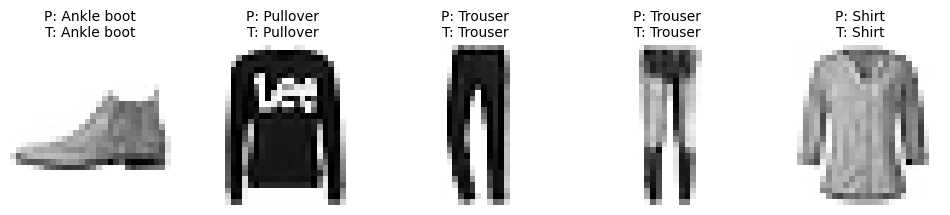

In [8]:
net.eval()
with torch.no_grad():
    images, labels = next(iter(testloader))

    images = images.to(device)
    labels = labels.to(device)

    y = net(images)

    plt.figure(figsize=(12,3))
    n = 5

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze().cpu(), cmap=plt.cm.Greys)
        plt.axis("off")

        pred = classes[torch.argmax(y[i]).item()]
        true = classes[labels[i].item()]

        plt.title(f"P: {pred}\nT: {true}", fontsize=10)

    plt.show()


### Data Augmentation

Data augmentation increases the diversity of the training data by applying transformations such as rotations or flips. This helps models learn features that are robust to small variations, reduces overfitting, and improves generalization. This is especially useful when the available dataset is limited and getting more data would be expensive.

In [9]:
aug_net = VGGNet()
aug_net.train()
aug_net.to(device)
aug_optimizer = optim.Adam(aug_net.parameters(), lr=0.01)

aug_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_aug_dataset = datasets.FashionMNIST(root="./data/aug", train=True, download=True, transform=aug_transform)
train_aug_loader  = DataLoader(train_aug_dataset, batch_size=32, shuffle=True)

train(aug_net, train_aug_loader, testloader, aug_optimizer, criterion, device, epochs)

epoch 1 | 0.8344
epoch 2 | 0.8603
epoch 3 | 0.875
epoch 4 | 0.8873
epoch 5 | 0.8899
epoch 6 | 0.8974
epoch 7 | 0.8811
epoch 8 | 0.8877
epoch 9 | 0.9052
epoch 10 | 0.9007


With a large dataset like Fashion-MNIST, the model already sees enough natural variation, so simple augmentations may add little benefit.

Additionally, training for only a few epochs may not give the model enough time to fully benefit from the increased data diversity introduced by augmentation.

## Summary

In this notebook, we trained a CNN from scratch and explored how data augmentation affects generalization. This illustrates the modern CV workflow of learning features automatically rather than designing them by hand.